In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 3c
commitnumber = d5931a1
conc = None
dv = 0.001
klin = 5e-25
molecule = h2o
ng_adju = [0]
ng_refs = [5]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 1
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(600, 250)]
tsfc = 294
vmax = 800
vmin = 720
w_diffuse = [(1.55, 1.6, 1.66, 1.66, 1.8)]
wgt = [(0.5, 0.5, 0.6, 0.7, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

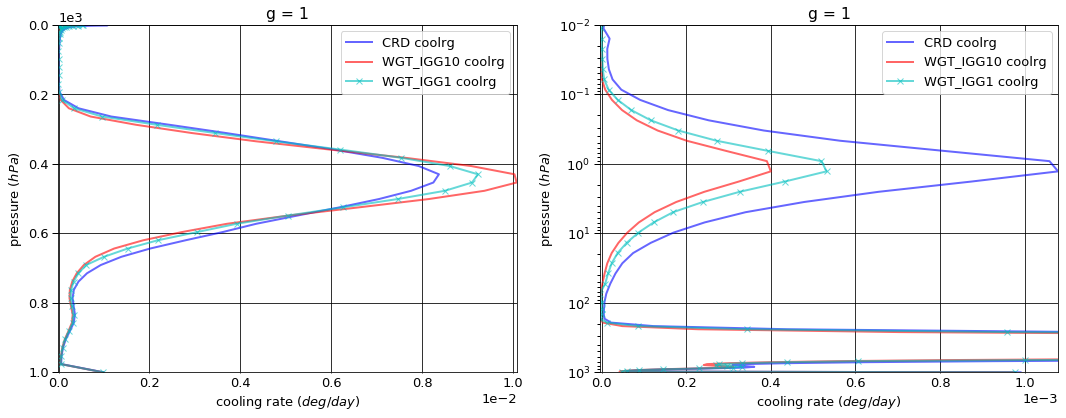

# Figure: cooling rate g-group 2

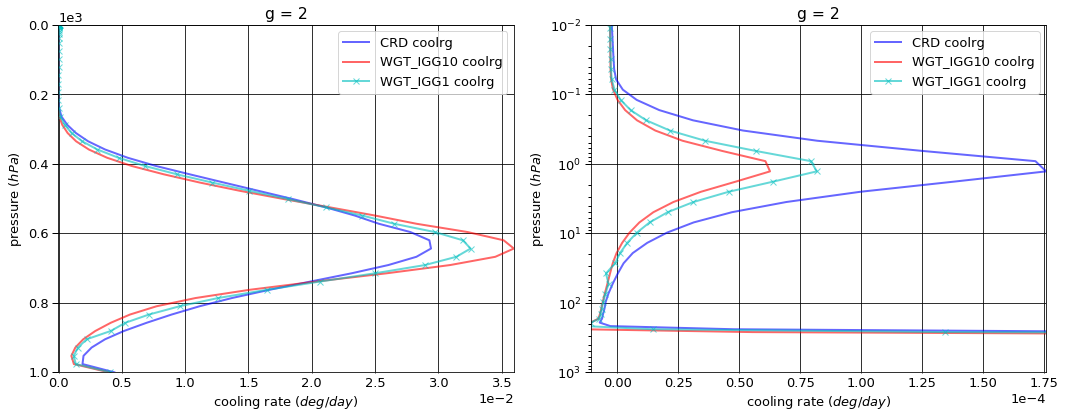

# Figure: cooling rate g-group 3

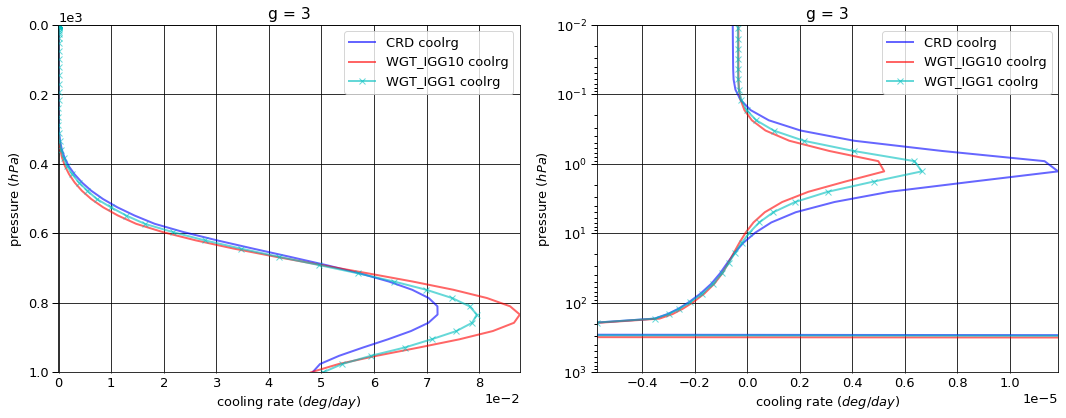

# Figure: cooling rate g-group 4

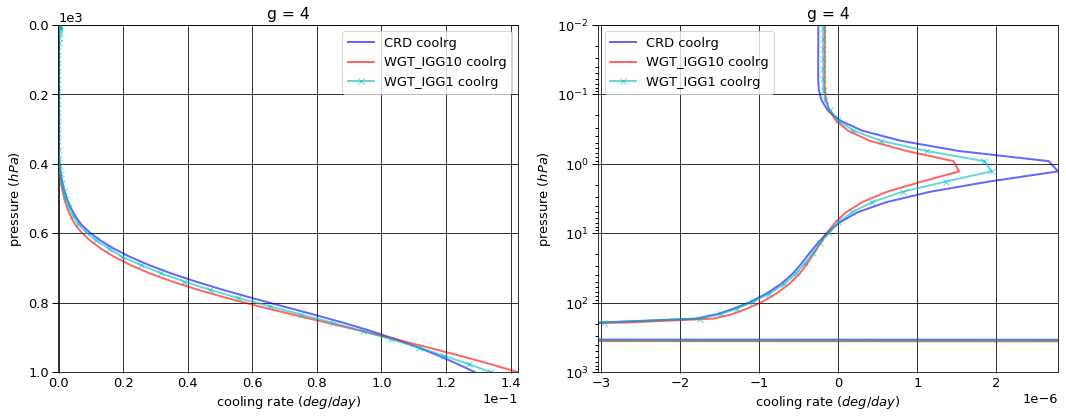

# Figure: cooling rate g-group 5

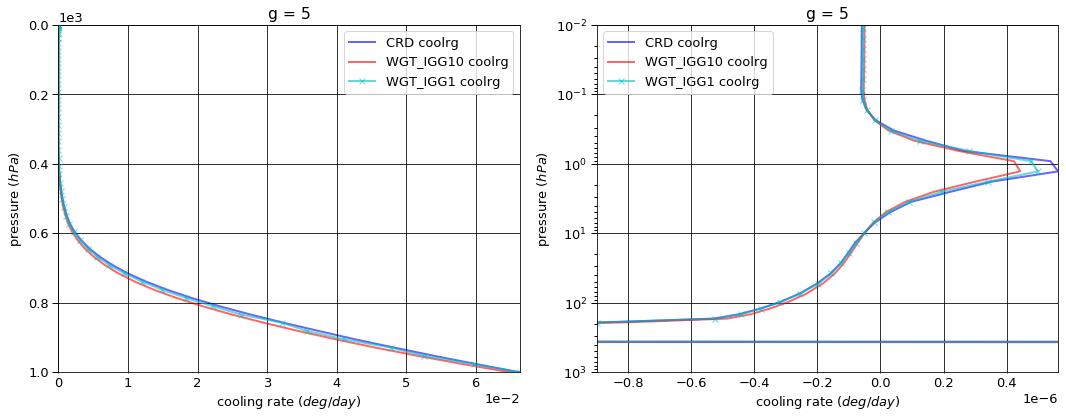

# Figure: cooling rate g-group total

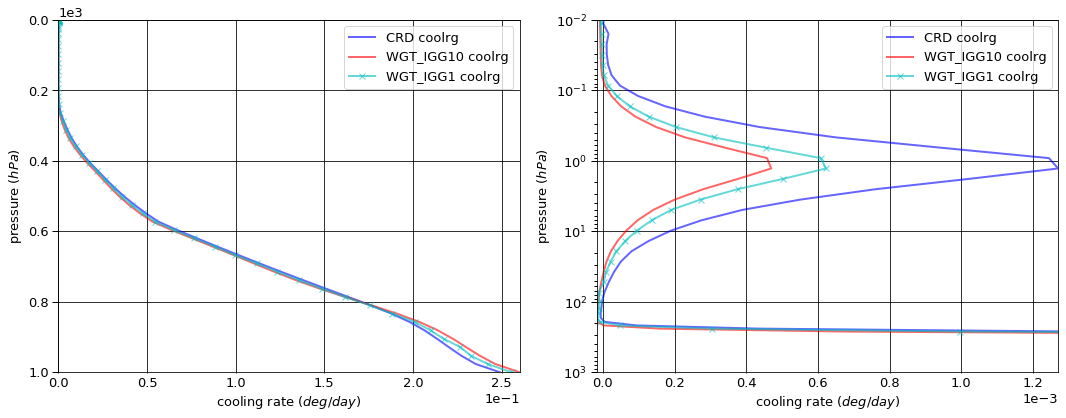

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.274361  0.000000  -0.274361
  1013.0   76     -0.509134  0.506378  -0.002757
2 0.0      1      -1.170071  0.000000  -1.170071
  1013.0   76     -1.686226  1.670793  -0.015433
3 0.0      1      -3.587907  0.000000  -3.587907
  1013.0   76     -4.185772  3.602554  -0.583219
4 0.0      1      -9.034106  0.000000  -9.034106
  1013.0   76     -9.446696  3.848085  -5.598611
5 0.0      1     -16.677471  0.000000 -16.677471
  1013.0   76    -16.809714  1.479391 -15.330322


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.274349  0.000000  -0.274349
  1013.0   76     -0.508083  0.505383  -0.002701
2 0.0      1      -1.171413  0.000000  -1.171413
  1013.0   76     -1.681576  1.669249  -0.012327
3 0.0      1      -3.586952  0.000000  -3.586952
  1013.0   76     -4.176010  3.841419  -0.334592
4 0.0      1      -9.073802  0.000000  -9.073802
  1013.0   76     -9.432188  3.667423  -5.764765
5 0.0      1     -16.720823  0.000000 -16.720823
  1013.0   76    -16.839686  1.371443 -15.468243


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.272786  0.000000  -0.272786
  1013.0   76     -0.508083  0.505371  -0.002712
2 0.0      1      -1.168375  0.000000  -1.168375
  1013.0   76     -1.681576  1.668338  -0.013238
3 0.0      1      -3.584736  0.000000  -3.584736
  1013.0   76     -4.176010  3.732051  -0.443959
4 0.0      1      -9.045017  0.000000  -9.045017
  1013.0   76     -9.432188  3.734319  -5.697869
5 0.0      1     -16.712094  0.000000 -16.712094
  1013.0   76    -16.839686  1.439394 -15.400292


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000011  0.000000  0.000011
  1013.0   76     0.001051 -0.000995  0.000056
2 0.0      1     -0.001342  0.000000 -0.001342
  1013.0   76     0.004651 -0.001544  0.003107
3 0.0      1      0.000955  0.000000  0.000955
  1013.0   76     0.009762  0.238865  0.248627
4 0.0      1     -0.039695  0.000000 -0.039695
  1013.0   76     0.014508 -0.180662 -0.166153
5 0.0      1     -0.043352  0.000000 -0.043352
  1013.0   76    -0.029972 -0.107948 -0.137921


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.001574  0.000000  0.001574
  1013.0   76     0.001051 -0.001007  0.000044
2 0.0      1      0.001696  0.000000  0.001696
  1013.0   76     0.004651 -0.002456  0.002195
3 0.0      1      0.003171  0.000000  0.003171
  1013.0   76     0.009762  0.129498  0.139260
4 0.0      1     -0.010911  0.000000 -0.010911
  1013.0   76     0.014508 -0.113766 -0.099258
5 0.0      1     -0.034623  0.000000 -0.034623
  1013.0   76    -0.029972 -0.039997 -0.069970

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.105274e-06
  1001.112500 75     9.905249e-04
2 0.000312    1     -3.632085e-06
  1001.112500 75     4.405322e-03
3 0.000312    1     -5.615492e-07
  1001.112500 75     4.831407e-02
4 0.000312    1     -2.458789e-07
  1001.112500 75     1.290113e-01
5 0.000312    1     -5.663044e-08
  1001.112500 75     6.636049e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -8.591533e-06
  1001.112500 75     9.745810e-04
2 0.000312    1     -3.391576e-06
  1001.112500 75     3.971939e-03
3 0.000312    1     -3.282128e-07
  1001.112500 75     4.800417e-02
4 0.000312    1     -1.637912e-07
  1001.112500 75     1.423761e-01
5 0.000312    1     -4.798457e-08
  1001.112500 75     6.498974e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -6.995240e-06
  1001.112500 75     9.778834e-04
2 0.000312    1     -3.521120e-06
  1001.112500 75     4.084755e-03
3 0.000312    1     -3.537962e-07
  1001.112500 75     5.031867e-02
4 0.000312    1     -1.840610e-07
  1001.112500 75     1.339508e-01
5 0.000312    1     -5.201931e-08
  1001.112500 75     6.631589e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -5.486259e-06
  1001.112500 75    -1.594389e-05
2 0.000312    1      2.405082e-07
  1001.112500 75    -4.333834e-04
3 0.000312    1      2.333364e-07
  1001.112500 75    -3.099070e-04
4 0.000312    1      8.208772e-08
  1001.112500 75     1.336472e-02
5 0.000312    1      8.645869e-09
  1001.112500 75    -1.370748e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.889966e-06
  1001.112500 75    -1.264144e-05
2 0.000312    1      1.109643e-07
  1001.112500 75    -3.205675e-04
3 0.000312    1      2.077530e-07
  1001.112500 75     2.004596e-03
4 0.000312    1      6.181796e-08
  1001.112500 75     4.939500e-03
5 0.000312    1      4.611130e-09
  1001.112500 75    -4.460400e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.743916,0.000000,-30.743916
1013.0,76,-32.637543,11.107201,-21.530342



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.827339,0.000000,-30.827339
1013.0,76,-32.637543,11.054917,-21.582627



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-30.783007,0.000000,-30.783007
1013.0,76,-32.637543,11.079473,-21.558070



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.342341e-02,0.000000,-0.083423
1013.0,76,4.000000e-08,-0.052284,-0.052285



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-3.909186e-02,0.000000,-0.039092
1013.0,76,4.000000e-08,-0.027728,-0.027729


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000008
1001.112500,75,0.249082



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000013
1001.112500,75,0.260316



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000011
1001.112500,75,0.255648



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000005
1001.112500,75,0.011235



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000004
1001.112500,75,0.006566


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.015650,0.015567
2,0.051862,0.051523
3,0.128675,0.127951
4,0.290013,0.288998
5,0.513800,0.515961


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.503807e-22
2,2.244651e-23
3,3.350469e-24
4,5.001064e-25
5,3.765264e-26


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.503807e-22,NaN,0.015650,0.015567,0.015650,0.015567,600.0
2,2.244651e-23,0.149265,0.051862,0.051523,0.067513,0.067090,600.0
3,3.350469e-24,0.149265,0.128675,0.127951,0.196188,0.195041,600.0
4,5.001064e-25,0.149265,0.290013,0.288998,0.486200,0.484039,600.0
5,3.765264e-26,0.075289,0.513800,0.515961,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
